<a href="https://colab.research.google.com/github/AdamChoong0095/Intelliharvest-code/blob/main/DNR_satelite_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping methods

In [ ]:
!pip install xarray
!pip install rioxarray
!pip install rasterio
!pip install pystac_client
!pip install odc-stac
!pip install stackstac
!pip install osmnx


In [ ]:
!pip install planetary_computer
!pip install sentinelhub

In [ ]:
import pyproj
import ee
import warnings
from sentinelhub import SentinelHubRequest, MimeType, CRS, BBox, SHConfig
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load
from scipy.spatial import Delaunay
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Retrieving the NDVI of farming districts using Sentinel-2

The following table (from ChatGPT) explains each of the different bands' purposes.

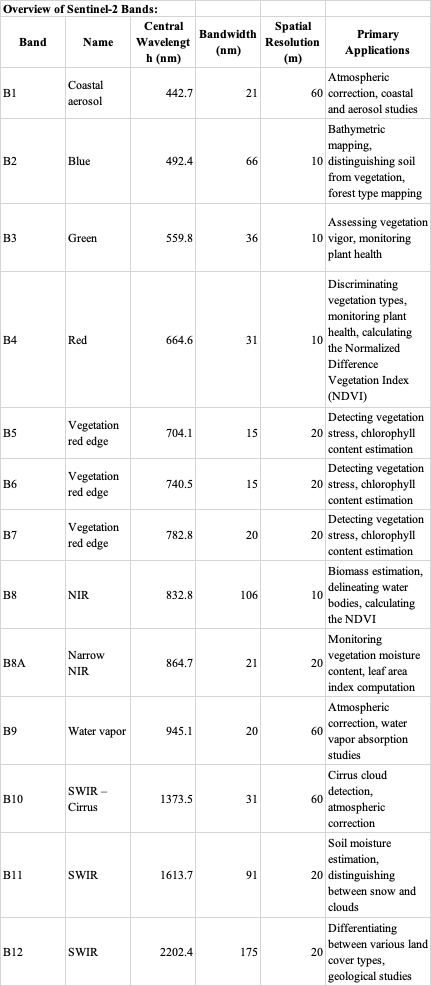

In [ ]:
#(lat,lon)
#bounds for sangli
lower_left = (16.8,74.5)
upper_right = (17,75)
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [ ]:
# Define the time windows for different seasons in 2023/24
winter_time_window="2023-12-01/2024-02-28"
pre_summer_time_window="2024-03-01/2024-05-30"
monsoon_time_window = "2024-06-01/2024-09-30"
post_monsoon_time_window="2024-01-10/2024-11-30"

In [ ]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

winter_search = stac.search(
    bbox=bounds,
    datetime=winter_time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)
pre_summer_search = stac.search(
    bbox=bounds,
    datetime=pre_summer_time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)
monsoon_search = stac.search(
      bbox=bounds,
      datetime=monsoon_time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)
post_monsoon_search = stac.search(
      bbox=bounds,
      datetime=post_monsoon_time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [ ]:
winter_items=list(winter_search.get_items())
print('The number of frames in our region during winter season:',len(winter_items))
pre_summer_items=list(pre_summer_search.get_items())
print('The number of frames in our region during pre-summer season:',len(pre_summer_items))
monsoon_items = list(monsoon_search.get_items())
print('The number of frames in our region during monsoon season:',len(monsoon_items))
post_monsoon_items=list(post_monsoon_search.get_items())
print('The number of frames in our region during post-monsoon season:',len(post_monsoon_items))

The number of frames in our region during winter season: 28
The number of frames in our region during pre-summer season: 32
The number of frames in our region during monsoon season: 2
The number of frames in our region during post-monsoon season: 62


In [ ]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [ ]:
winter_data = stac_load(
    winter_items,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A"],#bands of interest are 2-8A
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)
pre_summer_data=stac_load(
    pre_summer_items,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A"],#bands of interest are 2-8A
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)
monsoon_data=stac_load(
    monsoon_items,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A"],#bands of interest are 2-8A
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)
post_monsoon_data=stac_load(
    post_monsoon_items,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A"],#bands of interest are 2-8A
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [ ]:
bands_int=['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A']#select only three to visualise

In [ ]:
#cell with high computational expense
winter_median = winter_data.median(dim="time").compute()

In [ ]:
#cell with high computational expense
pre_summer_median = pre_summer_data.median(dim="time").compute()

In [ ]:
monsoon_median=monsoon_data.median(dim="time").compute()

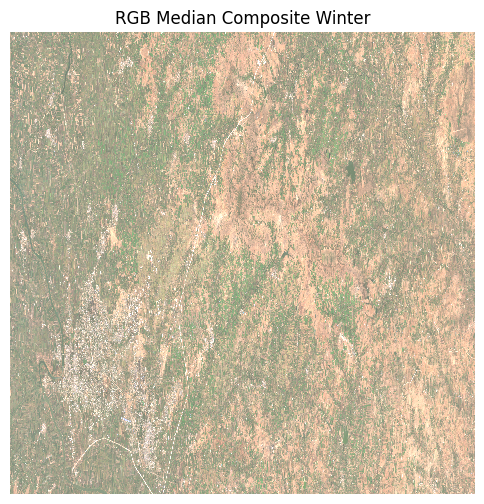

In [ ]:
# Plot an RGB image for the median composite or mosaic
fig, ax = plt.subplots(figsize=(6,6))
winter_median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite Winter")
ax.axis('off')
plt.show()

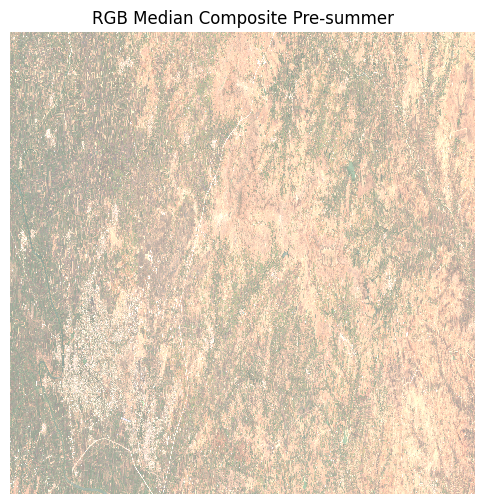

In [ ]:
# Plot an RGB image for the median composite or mosaic
fig, ax = plt.subplots(figsize=(6,6))
pre_summer_median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite Pre-summer")
ax.axis('off')
plt.show()

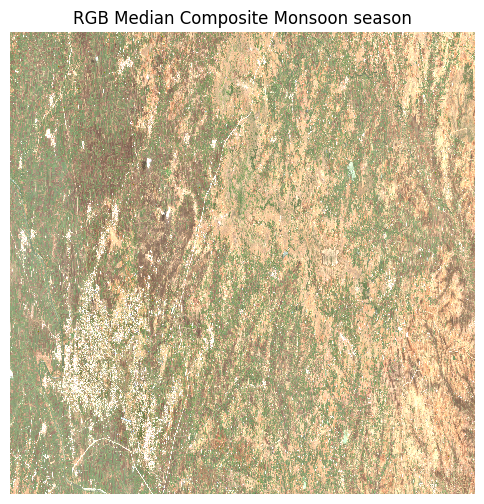

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
monsoon_median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite Monsoon season")
ax.axis('off')
plt.show()

In [ ]:
# Calculate NDVI for the median mosaic
ndvi_winter_median = (winter_median.B08-median.B04)/(median.B08+median.B04)

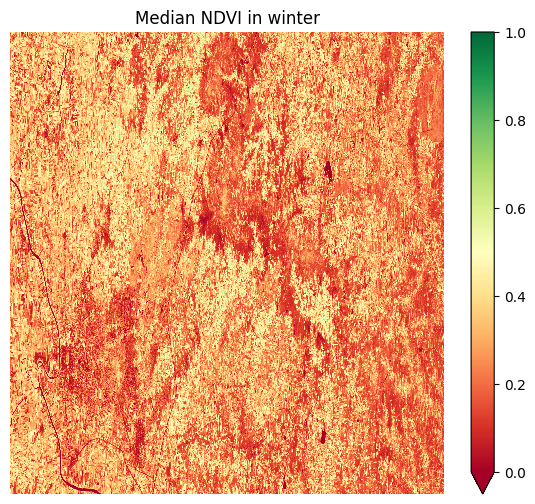

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_winter_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI in winter")
plt.axis('off')
plt.show()

In [ ]:
ndvi_pre_summer_median = (pre_summer_median.B08-median.B04)/(median.B08+median.B04)

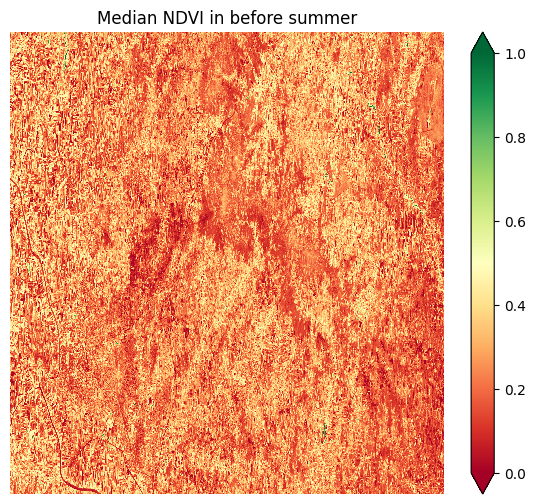

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_pre_summer_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI in before summer")
plt.axis('off')
plt.show()

In [ ]:
ndvi_monsoon_median=(monsoon_median.B08-median.B04)/(median.B08+median.B04)

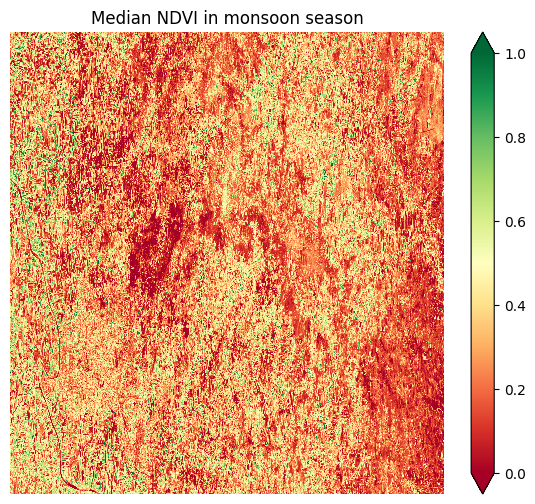

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_monsoon_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI in monsoon season")
plt.axis('off')
plt.show()

In [ ]:
#save as tiff
filename = "winter_season.tiff"
data_slice = winter_data.isel(time=7)
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]

In [ ]:
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);

In [ ]:
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=4,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B02,1)
    dst.write(data_slice.B04,2)
    dst.write(data_slice.B06,3)
    dst.write(data_slice.B08,4)
    dst.close()

In [ ]:
#save as tiff
filename = "pre_summer_season.tiff"
data_slice = pre_summer_data.isel(time=7)
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]

In [ ]:
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);

In [ ]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=4,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B02,1)
    dst.write(data_slice.B04,2)
    dst.write(data_slice.B06,3)
    dst.write(data_slice.B08,4)
    dst.close()

In [ ]:
# Show the location and size of the new output file
!ls *.tiff

pre_summer_season.tiff	winter_season.tiff
